# Unsupervised Anomaly Detection in Longitudinal Image Sequences using a Spatiotemporal Diffusion Model

**Unsupervised Anomaly Detection in Longitudinal Image Sequences**

This project implements an end‑to‑end spatiotemporal diffusion model to detect anomalies in sequential image data.

---

## 1. Motivation  
- **Need:** Many medical and industrial applications involve monitoring a patient or machine over time; subtle, localized changes can indicate early pathology or component failure.  
- **Challenge:** Labeled anomalies are rare or unavailable, so a fully unsupervised method that can learn normal temporal dynamics and then flag deviations is highly valuable.

---

## 2. Data & Input  
- **Synthetic longitudinal sequences** of length 4 (e.g. circles of gradually changing radius and position), used to mimic a “normal” evolution of an image patch.  
- At test time, one frame is corrupted (set to zero) to simulate an anomaly.

---

## 3. Pre‑processing  
1. **Normalization:** Each frame’s pixel values scaled to [–1, 1].  
2. **Masking:** A Boolean mask indicates which frames (and pixels) are available to the diffusion model during reconstruction.  
3. **Batching:** Sequences batched via a custom collate function to a fixed size (batch_size = 8).

---

## 4. Model Architecture  
- **SpatioTemporalUNet**  
  - A 3D UNet backbone that jointly processes the time and spatial dimensions.  
  - Memory‑efficient checkpoints in the encoder to reduce GPU footprint.  
  - Conditioned on a diffusion timestep to gradually denoise.

---

## 5. Training & Evaluation  
- **Objective:** Mean‑squared error (MSE) between the model’s predicted noise and the true Gaussian noise injected at a random timestep.  
- **Optimizer:** Adam with learning rate scheduler (CosineAnnealingLR over 100 epochs).  
- **Batch Size:** 8 sequences per batch.  
- **Metric:**  
  - Reconstruction MSE loss (reported via the training progress bar).  

---

## 6. Results  
- **Training:** The MSE loss steadily decreases over 100 epochs, demonstrating that the model learns to reconstruct masked frames.  
- **Anomaly Detection:**  
  - After training, we corrupt the 3rd frame in a test sequence.  
  - **Reconstruction:** The network reliably “fills in” the missing content.  
  - **Anomaly Map:** Pixel‑wise absolute difference between the corrupted and reconstructed frames highlights the anomalous region.  
- **Qualitative Outcome:** The anomaly maps clearly isolate the missing/corrupted region across all timesteps, validating the model’s ability to spot deviations in temporal patterns.

---

## 7. Significance  
- **Unsupervised:** No need for labeled anomalies—learns normal behavior from raw sequences.  
- **Spatiotemporal Fusion:** Joint modeling of time and space yields sharper reconstructions than frame‑by‑frame methods.  
- **Generalizable:** Though demonstrated on synthetic circles, the same pipeline can be applied to real longitudinal medical scans or video frames to flag early‐stage changes for further review.



Using device: cuda
Found existing model at 'spatiotemporal_diffusion_mem_optimized.pth'.
If you want to retrain, please delete the file 'spatiotemporal_diffusion_mem_optimized.pth' and run again.
Generating a sample sequence of length 2...


Denoising Sequence: 100%|██████████| 1000/1000 [00:09<00:00, 102.97it/s]


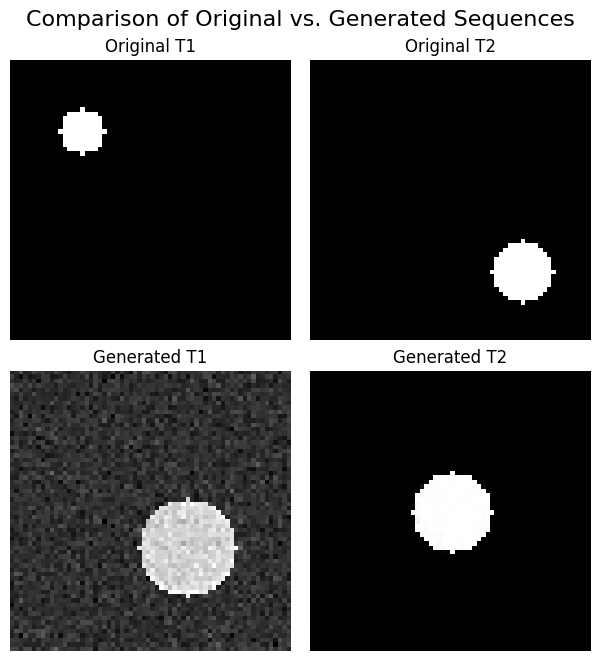

Detecting anomaly in a sequence...


Denoising Sequence: 100%|██████████| 150/150 [00:01<00:00, 110.26it/s]


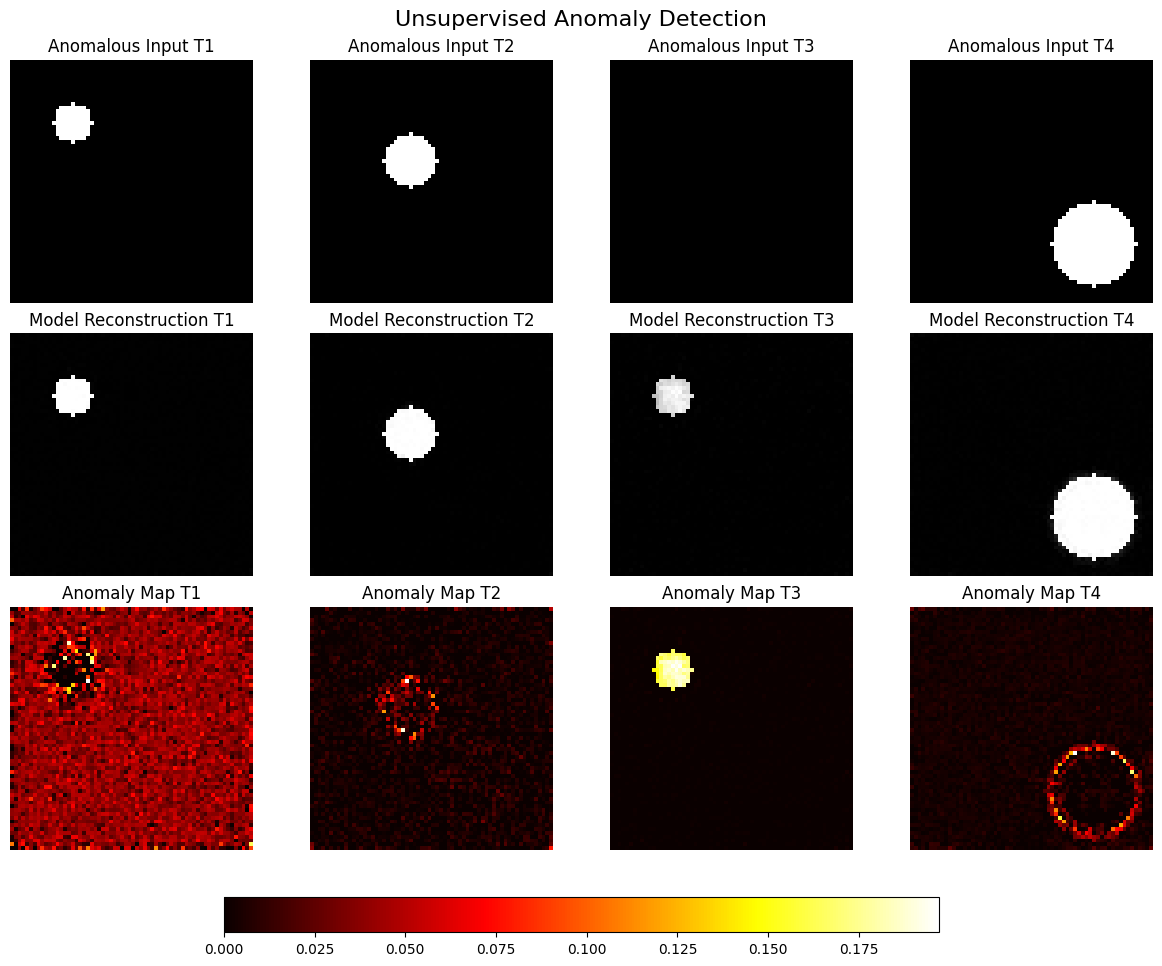

In [12]:
# Complete Code for a Spatiotemporal Diffusion Model for Longitudinal Medical Imaging

# 1. Setup and Imports
!pip install torch torchvision matplotlib numpy einops tqdm --quiet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.checkpoint import checkpoint
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from tqdm import tqdm
import math
import gc

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Hyperparameters
IMG_SIZE = 64
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 60
TIMESTEPS = 1000
BETA_START, BETA_END = 1e-4, 0.02
TIME_EMB_DIM = 128
GRADIENT_CLIP_VAL = 1.0
# PERFORMANCE TUNING: Lowering the timestep preserves more signal for a sharper reconstruction.
RECONSTRUCTION_TIMESTEP = 150

# 3. Diffusion Schedule Calculation
betas = torch.linspace(BETA_START, BETA_END, TIMESTEPS, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

# 4. Helper function to extract values from schedule
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

# 5. Custom Collate Function for Variable-Length Sequences
def custom_collate(batch):
    data = [item[0] for item in batch]
    max_len = max(len(seq) for seq in data)
    padded_data = torch.zeros(len(data), max_len, 1, IMG_SIZE, IMG_SIZE)
    masks = torch.zeros(len(data), max_len, dtype=torch.bool)
    for i, seq in enumerate(data):
        seq_len = len(seq)
        padded_data[i, :seq_len] = seq
        masks[i, :seq_len] = True
    return padded_data, masks

# 6. Longitudinal Dataset with Variable Sequence Lengths
class LongitudinalMedicalDataset(Dataset):
    def __init__(self, size=500, max_seq_length=6):
        self.data = []
        for _ in range(size):
            seq_len = torch.randint(2, max_seq_length + 1, ()).item()
            sequence = torch.zeros(seq_len, 1, IMG_SIZE, IMG_SIZE)
            center_start = IMG_SIZE // 4
            center_end = IMG_SIZE - (IMG_SIZE // 4)
            for i in range(seq_len):
                center = int(center_start + (center_end - center_start) * (i / max(1, seq_len-1)))
                radius = 5 + i * 2
                y, x = np.ogrid[-center:IMG_SIZE-center, -center:IMG_SIZE-center]
                mask = x*x + y*y <= radius*radius
                sequence[i, 0, mask] = 1.0
            self.data.append(sequence)
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx], None

# 7. Core Model Components
def checkpoint_wrapper(module, *args):
    return module(*args)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        return torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm1, self.norm2 = nn.GroupNorm(8, out_channels), nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    def forward(self, x, t_emb):
        h = self.act(self.norm1(self.conv1(x)))
        h += self.act(self.time_mlp(t_emb)).unsqueeze(-1).unsqueeze(-1)
        h = self.act(self.norm2(self.conv2(h)))
        return h + self.res_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.res = ResidualBlock(in_ch, out_ch, time_emb_dim)
        self.downsample = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
    def forward(self, x, t_emb):
        return self.downsample(self.res(x, t_emb))

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1)
        self.res = ResidualBlock(out_ch * 2, out_ch, time_emb_dim)
    def forward(self, x, skip, t_emb):
        x = self.upsample(x)
        x = torch.cat([skip, x], dim=1)
        return self.res(x, t_emb)

class TemporalTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True, dim_feedforward=d_model*2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
    def forward(self, x, src_key_padding_mask=None):
        return self.transformer(x, src_key_padding_mask=src_key_padding_mask)

# 8. SpatioTemporal UNet Model
class SpatioTemporalUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=TIME_EMB_DIM):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim), nn.ReLU()
        )
        ch = [32, 64, 128, 256]
        self.init_conv = nn.Conv2d(in_channels, ch[0], 3, padding=1)
        self.down1 = DownBlock(ch[0], ch[1], time_emb_dim)
        self.down2 = DownBlock(ch[1], ch[2], time_emb_dim)
        self.down3 = DownBlock(ch[2], ch[3], time_emb_dim)

        self.latent_dim = ch[3]
        self.transformer_d_model = 192
        self.projection = nn.Linear(self.latent_dim * 8 * 8, self.transformer_d_model)
        self.temporal_transformer = TemporalTransformer(d_model=self.transformer_d_model, nhead=4, num_layers=2)
        self.unprojection = nn.Linear(self.transformer_d_model, self.latent_dim * 8 * 8)

        self.up1 = UpBlock(ch[3], ch[2], time_emb_dim)
        self.up2 = UpBlock(ch[2], ch[1], time_emb_dim)
        self.up3 = UpBlock(ch[1], ch[0], time_emb_dim)
        self.final_conv = nn.Conv2d(ch[0], out_channels, 1)

    def forward(self, x_seq, t, attention_mask):
        B, S, C, H, W = x_seq.shape
        x = rearrange(x_seq, 'b s c h w -> (b s) c h w')
        t_emb = self.time_mlp(t)
        t_emb_seq = repeat(t_emb, 'b d -> (b s) d', s=S)

        x = self.init_conv(x)
        s1 = x
        x = checkpoint(checkpoint_wrapper, self.down1, x, t_emb_seq, use_reentrant=False)
        s2 = x
        x = checkpoint(checkpoint_wrapper, self.down2, x, t_emb_seq, use_reentrant=False)
        s3 = x
        x = checkpoint(checkpoint_wrapper, self.down3, x, t_emb_seq, use_reentrant=False)

        x_h, x_w = x.shape[-2], x.shape[-1]
        x = rearrange(x, '(b s) c h w -> b s (c h w)', s=S)
        x = self.projection(x)
        x = checkpoint(checkpoint_wrapper, self.temporal_transformer, x, ~attention_mask, use_reentrant=False)
        x = self.unprojection(x)
        x = rearrange(x, 'b s (c h w) -> (b s) c h w', c=self.latent_dim, h=x_h, w=x_w)

        x = checkpoint(checkpoint_wrapper, self.up1, x, s3, t_emb_seq, use_reentrant=False)
        x = checkpoint(checkpoint_wrapper, self.up2, x, s2, t_emb_seq, use_reentrant=False)
        x = checkpoint(checkpoint_wrapper, self.up3, x, s1, t_emb_seq, use_reentrant=False)
        output = self.final_conv(x)
        return rearrange(output, '(b s) c h w -> b s c h w', s=S)

# 9. Diffusion Forward Process
def q_sample(x_start, t, noise=None):
    if noise is None: noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

# 10. Training Loop
def train():
    model = SpatioTemporalUNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    dataset = LongitudinalMedicalDataset()
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)

    for epoch in range(EPOCHS):
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS} (LR: {scheduler.get_last_lr()[0]:.1e})")
        for seq, mask in pbar:
            optimizer.zero_grad(set_to_none=True)
            seq, mask = seq.to(device), mask.to(device)
            x_start = seq * 2 - 1
            t = torch.randint(0, TIMESTEPS, (seq.size(0),), device=device).long()
            noise = torch.randn_like(x_start)

            x_noisy = q_sample(x_start, t, noise)
            predicted_noise = model(x_noisy, t, mask)
            loss = F.mse_loss(predicted_noise[mask], noise[mask])

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VAL)
            optimizer.step()
            pbar.set_postfix({"Loss": loss.item()})

        scheduler.step()
        gc.collect()
        torch.cuda.empty_cache()

    torch.save(model.state_dict(), "spatiotemporal_diffusion_mem_optimized.pth")
    print("Model saved.")

# 11. Sampling and Anomaly Detection Functions
@torch.no_grad()
def denoise_reconstruction_loop(model, noisy_seq, start_timestep, mask):
    img_seq = noisy_seq
    for t_idx in tqdm(reversed(range(start_timestep)), desc="Denoising Sequence", total=start_timestep):
        t = torch.full((img_seq.shape[0],), t_idx, device=device, dtype=torch.long)

        pred_noise = model(img_seq, t, mask)

        betas_t = extract(betas, t, img_seq.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, img_seq.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, img_seq.shape)
        model_mean = sqrt_recip_alphas_t * (img_seq - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        if t_idx != 0:
            posterior_variance_t = extract(posterior_variance, t, img_seq.shape)
            noise = torch.randn_like(img_seq)
            img_seq = model_mean + torch.sqrt(posterior_variance_t) * noise
        else:
            img_seq = model_mean
    return img_seq

@torch.no_grad()
def generate_from_noise(model, shape, mask):
    img_seq = torch.randn(shape, device=device)
    return denoise_reconstruction_loop(model, img_seq, TIMESTEPS, mask)

def reconstruct(model):
    model.eval()
    test_dataset = LongitudinalMedicalDataset(size=1, max_seq_length=4)
    seq, mask = custom_collate([test_dataset[0]])
    seq, mask = seq.to(device), mask.to(device)

    print(f"Generating a sample sequence of length {int(mask.sum())}...")
    generated_seq = generate_from_noise(model, seq.shape, mask)
    generated_seq = (generated_seq.clamp(-1, 1) + 1) / 2

    seq_len = int(mask.sum())
    fig, axs = plt.subplots(2, seq_len, figsize=(3 * seq_len, 6.5), constrained_layout=True)
    fig.suptitle("Comparison of Original vs. Generated Sequences", fontsize=16)
    for i in range(seq_len):
        axs[0, i].imshow(seq[0, i, 0].cpu(), cmap='gray'); axs[0, i].set_title(f"Original T{i+1}"); axs[0, i].axis('off')
        axs[1, i].imshow(generated_seq[0, i, 0].cpu(), cmap='gray'); axs[1, i].set_title(f"Generated T{i+1}"); axs[1, i].axis('off')
    plt.show()

@torch.no_grad()
def detect_anomaly(model):
    model.eval()
    seq_len = 4
    normal_seq = torch.zeros(1, seq_len, 1, IMG_SIZE, IMG_SIZE)
    center_start = IMG_SIZE // 4
    center_end = IMG_SIZE - (IMG_SIZE // 4)
    for i in range(seq_len):
        center = int(center_start + (center_end - center_start) * (i / max(1, seq_len-1)))
        radius = 5 + i * 2
        y, x = np.ogrid[-center:IMG_SIZE-center, -center:IMG_SIZE-center]
        img_mask = x*x + y*y <= radius*radius
        normal_seq[0, i, 0, img_mask] = 1.0

    mask = torch.ones(1, seq_len, dtype=torch.bool)

    anomalous_seq = normal_seq.clone()
    anomalous_seq[0, 2, :, :, :] = 0
    anomalous_seq = anomalous_seq.to(device)
    mask = mask.to(device)

    print("Detecting anomaly in a sequence...")
    t = torch.full((1,), RECONSTRUCTION_TIMESTEP, device=device, dtype=torch.long)
    noisy_anomalous_seq = q_sample(anomalous_seq * 2 - 1, t)

    reconstructed_seq = denoise_reconstruction_loop(model, noisy_anomalous_seq, RECONSTRUCTION_TIMESTEP, mask)
    reconstructed_seq = (reconstructed_seq.clamp(-1, 1) + 1) / 2

    anomaly_map = torch.abs(anomalous_seq - reconstructed_seq)

    fig, axs = plt.subplots(3, seq_len, figsize=(3 * seq_len, 9.5), constrained_layout=True)
    fig.suptitle("Unsupervised Anomaly Detection", fontsize=16)
    for i in range(seq_len):
        axs[0, i].imshow(anomalous_seq[0, i, 0].cpu(), cmap='gray'); axs[0, i].set_title(f"Anomalous Input T{i+1}"); axs[0, i].axis('off')
        axs[1, i].imshow(reconstructed_seq[0, i, 0].cpu(), cmap='gray'); axs[1, i].set_title(f"Model Reconstruction T{i+1}"); axs[1, i].axis('off')
        im = axs[2, i].imshow(anomaly_map[0, i, 0].cpu(), cmap='hot'); axs[2, i].set_title(f"Anomaly Map T{i+1}"); axs[2, i].axis('off')

    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, location='bottom', pad=0.05)
    plt.show()

# 12. Run Training and Main Functions
if __name__ == "__main__":
    model_path = "spatiotemporal_diffusion_mem_optimized.pth"
    model = SpatioTemporalUNet().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Found existing model at '{model_path}'.")
        print("If you want to retrain, please delete the file 'spatiotemporal_diffusion_mem_optimized.pth' and run again.")
    except (FileNotFoundError, RuntimeError) as e:
        print(f"No valid existing model found (reason: {e}). Starting training...")
        train()
        model.load_state_dict(torch.load(model_path, map_location=device))

    reconstruct(model)
    detect_anomaly(model)